In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
import seaborn as sns
from sklearn.utils import resample

# 1. Predicting Aggregate Measure with KBest

Our aggregate measure of vascular risk is a discrete categorical variable. Therefore,
we considered that the optimal algorithm to predict it is a supervised learning model
for the classification of the aggregate measure, which values range from 0 to 5. In
addition, due to the imbalanced nature of our target variable, we considered that
the best algorithm to choose is Random Forest (RF) from the "ensemble" class in
Scikit-learn [1].

In [2]:
# Loading the data
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1428)

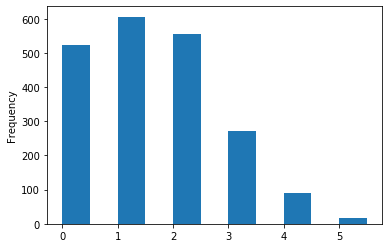

In [3]:
# Cardiovascular risk score
Y0 = data["agg_score"]
bin_values = np.arange(start=0, stop=6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [4]:
# Splitting each class from our target variable
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S345 = pd.concat((S3, S4, S5), axis=0)
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape, S345.shape

((523, 1428),
 (606, 1428),
 (555, 1428),
 (273, 1428),
 (91, 1428),
 (17, 1428),
 (381, 1428))

Random oversampling involves randomly duplicating examples from the minority
class and adding them to the training dataset. Examples from the training dataset are
selected randomly with replacement. This means that examples from the minority
class can be chosen and added to the new “more balanced” training dataset multiple
times.

In [5]:
# Oversample minority class
S0_over = resample(S0, replace=True, n_samples=606, random_state=123) 
S_0vs1 = pd.concat((S0_over, S1), axis=0)
S0_over2 = resample(S0, replace=True, n_samples=555, random_state=123)
S_0vs2 = pd.concat((S0_over2, S2), axis=0)
S3_over = resample(S3, replace=True, n_samples=523, random_state=123)
S_0vs3 = pd.concat((S0, S3_over), axis=0)
S4_over = resample(S4, replace=True, n_samples=523, random_state=123)
S_0vs4 = pd.concat((S0, S4_over), axis=0)
S5_over = resample(S5, replace=True, n_samples=523, random_state=123)
S_0vs5 = pd.concat((S0, S5_over), axis=0)
S345_over = resample(S345, replace=True, n_samples=523, random_state=123)
S_0vs345 = pd.concat((S0, S345_over), axis=0)
S_0vs1.shape, S_0vs2.shape, S_0vs3.shape, S_0vs4.shape, S_0vs5.shape, S_0vs345.shape 

((1212, 1428),
 (1110, 1428),
 (1046, 1428),
 (1046, 1428),
 (1046, 1428),
 (1046, 1428))

In [6]:
# Mapping values in binarized targets
S_0vs1["agg_score"] = S_0vs1["agg_score"].map({0:0, 1:1})
S_0vs2["agg_score"] = S_0vs2["agg_score"].map({0:0, 2:1})
S_0vs3["agg_score"] = S_0vs3["agg_score"].map({0:0, 3:1})
S_0vs4["agg_score"] = S_0vs4["agg_score"].map({0:0, 4:1})
S_0vs5["agg_score"] = S_0vs5["agg_score"].map({0:0, 5:1})
S_0vs345["agg_score"] = S_0vs345["agg_score"].map({0:0, 3:1, 4:1, 5:1})

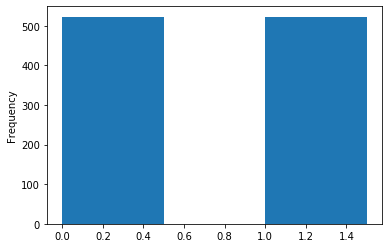

In [7]:
# Visualizing binary target class
Y0 = S_0vs5["agg_score"]
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [8]:
# Filtering data groups
heart_df = S_0vs5.filter(regex='heart')
cardio_cmr_df = S_0vs5.filter(regex='cardio_cmr')
brain_df = S_0vs5.filter(regex='brain')
heart_df.shape, brain_df.shape, cardio_cmr_df.shape

((1046, 630), (1046, 744), (1046, 9))

In [9]:
# our model
RF = RandomForestClassifier()

This popular technique consists of a combination of decision trees (DTs) trained on
different random samples of the training set. Each DT is a set of rules based on the
input features values optimized for accurately classifying all elements of the training
set. DTs are nonlinear models and tend to have high variance

## 1.1 Predicting aggregate measure of vascular risk with heart variables

In [10]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df

In [11]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 630), (314, 630), (732,), (314,))

In [12]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [14]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9808917197452229

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       165
           1       0.96      1.00      0.98       149

    accuracy                           0.98       314
   macro avg       0.98      0.98      0.98       314
weighted avg       0.98      0.98      0.98       314



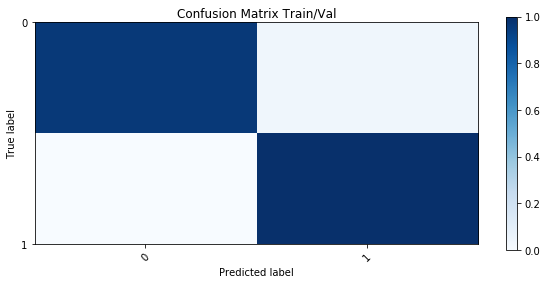

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
cols = selector.get_support(indices=True)
features = heart_df.iloc[:,cols]
K_best_heart = list(features) 
K_best_heart

['heart_SurfaceAreatoVolumeRatio_MYO_ED_shape',
 'heart_SurfaceAreatoVolumeRatio_MYO_ES_shape',
 'heart_Minimum_LV_ES_intensity',
 'heart_Percentile10_LV_ES_intensity',
 'heart_Median_MYO_ES_intensity']

In [18]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [20]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [21]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

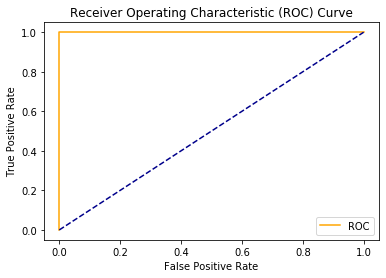

In [22]:
plot_roc_curve(fpr, tpr)

## 1.2 Predicting aggregate measure of vascular risk with CMR variables

In [23]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df

In [24]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 9), (314, 9), (732,), (314,))

In [25]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [27]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9904458598726115

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       165
           1       0.98      1.00      0.99       149

    accuracy                           0.99       314
   macro avg       0.99      0.99      0.99       314
weighted avg       0.99      0.99      0.99       314



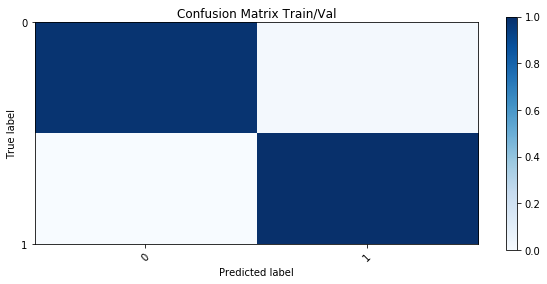

In [29]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
cols = selector.get_support(indices=True)
features = cardio_cmr_df.iloc[:,cols]
K_best_cmr = list(features) 
K_best_cmr

['cardio_cmr_LVEDV_i',
 'cardio_cmr_LVESV_i',
 'cardio_cmr_LVSV_i',
 'cardio_cmr_RVEDV_i',
 'cardio_cmr_RVSV_i']

In [31]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [32]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [33]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [34]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

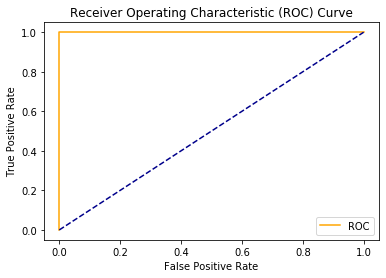

In [35]:
plot_roc_curve(fpr, tpr)

## 1.3 Predicting aggregate measure of vascular risk with brain variables

In [36]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = brain_df

In [37]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 744), (314, 744), (732,), (314,))

In [38]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [40]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       149

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



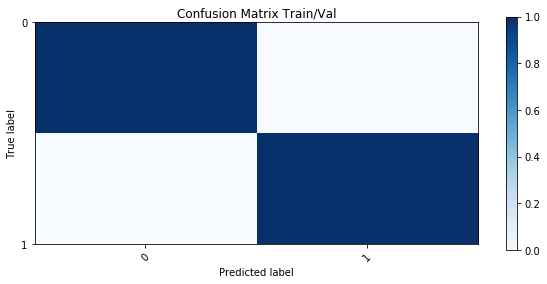

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
cols = selector.get_support(indices=True)
features = brain_df.iloc[:,cols]
K_best_brain = list(features) 
K_best_brain

['brain_bio_median_t2star_in_hippocampus__right__0_imaging',
 'brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging']

In [44]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [45]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [46]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

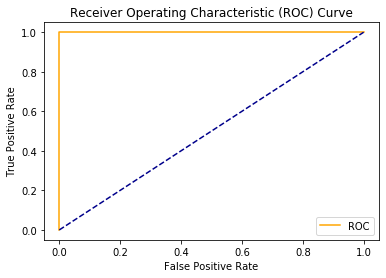

In [47]:
plot_roc_curve(fpr, tpr)

## 1.4 Predicting aggregate measure of vascular risk with heart/brain combinations

In [48]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df
X2 = brain_df
X1.shape, X2.shape

((1046, 630), (1046, 744))

In [49]:
# Combining datasets
X_combination_cfa = pd.concat((X1, X2), axis=1)
X_combination_cfa.shape

(1046, 1374)

In [50]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_combination_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 1374), (314, 1374), (732,), (314,))

In [51]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [53]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9936305732484076

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       165
           1       0.99      1.00      0.99       149

    accuracy                           0.99       314
   macro avg       0.99      0.99      0.99       314
weighted avg       0.99      0.99      0.99       314



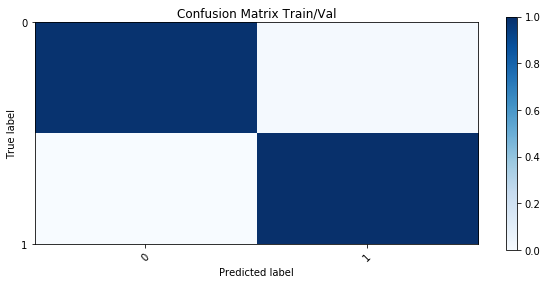

In [55]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
cols = selector.get_support(indices=True)
features = X_combination_cfa.iloc[:,cols]
K_best_heart_brain = list(features) 
K_best_heart_brain

['heart_SurfaceAreatoVolumeRatio_MYO_ES_shape',
 'heart_Percentile10_LV_ES_intensity',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging']

In [57]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [58]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [59]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

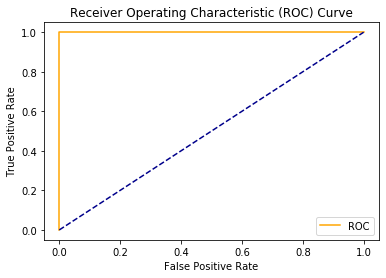

In [60]:
plot_roc_curve(fpr, tpr)

## 1.5 Predicting aggregate measure of vascular risk with CMR/brain combinations

In [61]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df
X2 = brain_df
X1.shape, X2.shape

((1046, 9), (1046, 744))

In [62]:
# Combining datasets
X_combination_cfa2 = pd.concat((X1, X2), axis=1)
X_combination_cfa2.shape

(1046, 753)

In [63]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_combination_cfa2, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 753), (314, 753), (732,), (314,))

In [64]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
# Dimensionality reduction
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [66]:
# Fitting the model and doing the predictions
RF.fit(X_kbest, y_train)
y_pred = RF.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       149

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



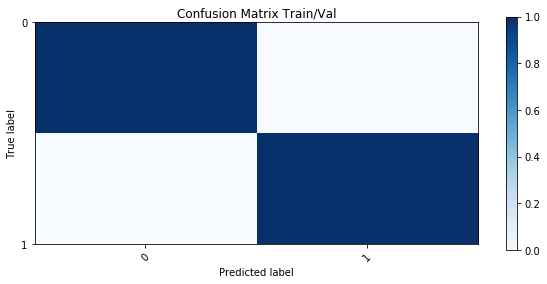

In [68]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
cols = selector.get_support(indices=True)
features = X_combination_cfa2.iloc[:,cols]
K_best_cmr_brain = list(features) 
K_best_cmr_brain

['brain_bio_median_t2star_in_hippocampus__right__0_imaging',
 'brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging',
 'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
 'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging']

In [70]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [71]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [72]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

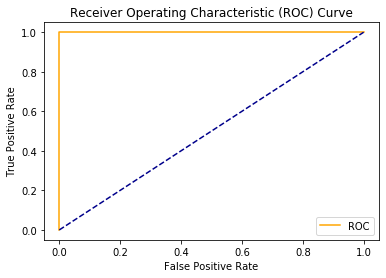

In [73]:
plot_roc_curve(fpr, tpr)

## 1.6 Correlation Plots

In [74]:
K_best_heart, K_best_cmr, K_best_brain, K_best_heart_brain, K_best_cmr_brain

(['heart_SurfaceAreatoVolumeRatio_MYO_ED_shape',
  'heart_SurfaceAreatoVolumeRatio_MYO_ES_shape',
  'heart_Minimum_LV_ES_intensity',
  'heart_Percentile10_LV_ES_intensity',
  'heart_Median_MYO_ES_intensity'],
 ['cardio_cmr_LVEDV_i',
  'cardio_cmr_LVESV_i',
  'cardio_cmr_LVSV_i',
  'cardio_cmr_RVEDV_i',
  'cardio_cmr_RVSV_i'],
 ['brain_bio_median_t2star_in_hippocampus__right__0_imaging',
  'brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging',
  'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
  'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
  'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging'],
 ['heart_SurfaceAreatoVolumeRatio_MYO_ES_shape',
  'heart_Percentile10_LV_ES_intensity',
  'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
  'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
  'brain_bio_inverted_

In [80]:
# Create dataframes
corr_heart_brain = data.filter(['heart_SurfaceAreatoVolumeRatio_MYO_ED_shape', 
                         'heart_SurfaceAreatoVolumeRatio_MYO_ES_shape',
                         'heart_Minimum_LV_ES_intensity',
                         'heart_Percentile10_LV_ES_intensity',
                         'heart_Median_MYO_ES_intensity',
                         'brain_bio_median_t2star_in_hippocampus__right__0_imaging',
                         'brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging',
                         'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
                         'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
                         'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging'], axis=1)

corr_cmr_brain = data.filter(['cardio_cmr_LVEDV_i', 
                         'cardio_cmr_LVESV_i',
                         'cardio_cmr_LVSV_i',
                         'cardio_cmr_RVEDV_i',
                         'cardio_cmr_RVSV_i',
                         'brain_bio_median_t2star_in_hippocampus__right__0_imaging',
                         'brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging',
                         'brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
                         'brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging',
                         'brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging'], axis=1)

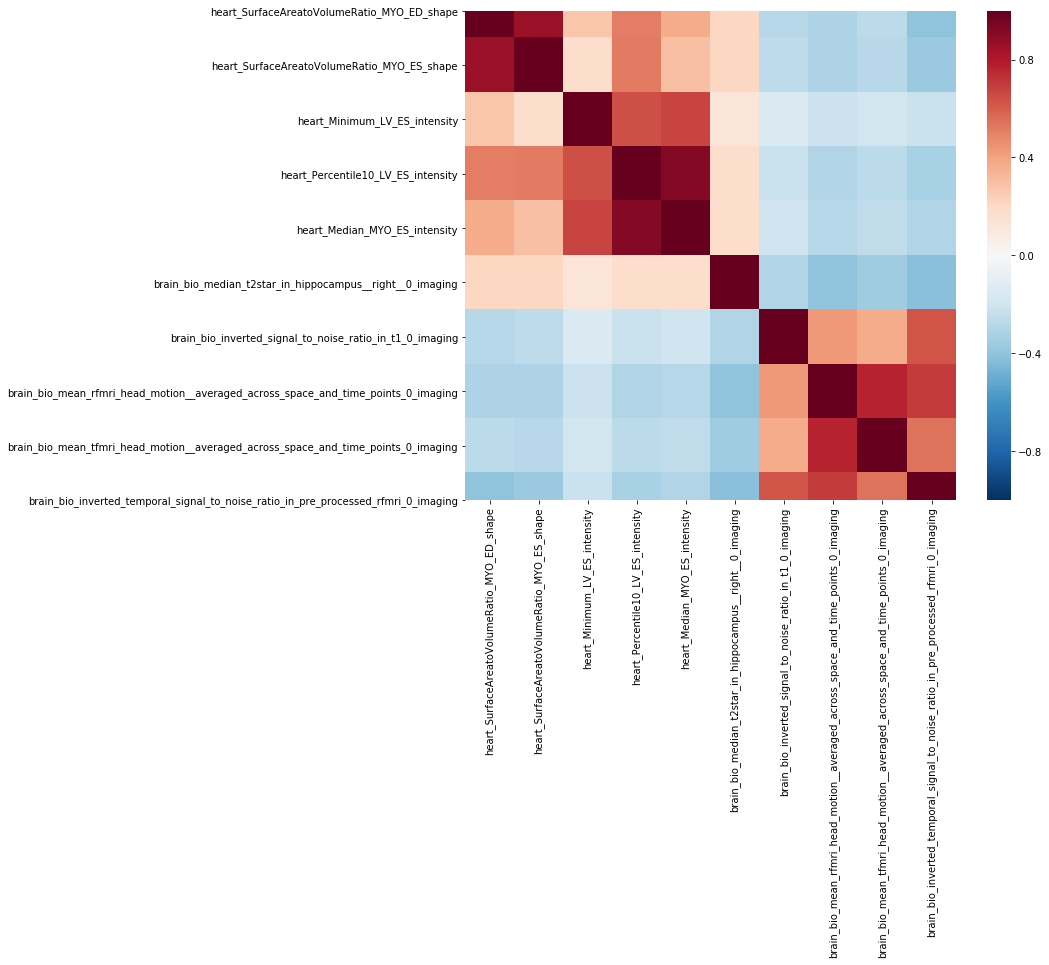

In [81]:
heart_brain_corr = corr_heart_brain.corr()
plt.figure(figsize=(11,9))
sns.heatmap(heart_brain_corr, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
plt.show()

In [82]:
heart_brain_corr

,heart_SurfaceAreatoVolumeRatio_MYO_ED_shape,heart_SurfaceAreatoVolumeRatio_MYO_ES_shape,heart_Minimum_LV_ES_intensity,heart_Percentile10_LV_ES_intensity,heart_Median_MYO_ES_intensity,brain_bio_median_t2star_in_hippocampus__right__0_imaging,brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging,brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging,brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging
heart_SurfaceAreatoVolumeRatio_MYO_ED_shape,1.000000,0.863370,0.274873,0.509728,0.374835,0.218493,-0.282066,-0.305453,-0.267613,-0.405059
heart_SurfaceAreatoVolumeRatio_MYO_ES_shape,0.863370,1.000000,0.182720,0.521280,0.302344,0.213308,-0.263978,-0.305184,-0.278184,-0.367506
heart_Minimum_LV_ES_intensity,0.274873,0.182720,1.000000,0.646551,0.676691,0.129961,-0.149487,-0.213547,-0.191378,-0.222703
heart_Percentile10_LV_ES_intensity,0.509728,0.521280,0.646551,1.000000,0.917512,0.186802,-0.219734,-0.297532,-0.269906,-0.327761
heart_Median_MYO_ES_intensity,0.374835,0.302344,0.676691,0.917512,1.000000,0.184225,-0.196649,-0.281848,-0.257148,-0.301215
brain_bio_median_t2star_in_hippocampus__right__0_imaging,0.218493,0.213308,0.129961,0.186802,0.184225,1.000000,-0.300674,-0.402202,-0.356125,-0.416952
brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging,-0.282066,-0.263978,-0.149487,-0.219734,-0.196649,-0.300674,1.000000,0.432335,0.370281,0.627819
brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.305453,-0.305184,-0.213547,-0.297532,-0.281848,-0.402202,0.432335,1.000000,0.770301,0.695842
brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.267613,-0.278184,-0.191378,-0.269906,-0.257148,-0.356125,0.370281,0.770301,1.000000,0.541515
brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging,-0.405059,-0.367506,-0.222703,-0.327761,-0.301215,-0.416952,0.627819,0.695842,0.541515,1.000000


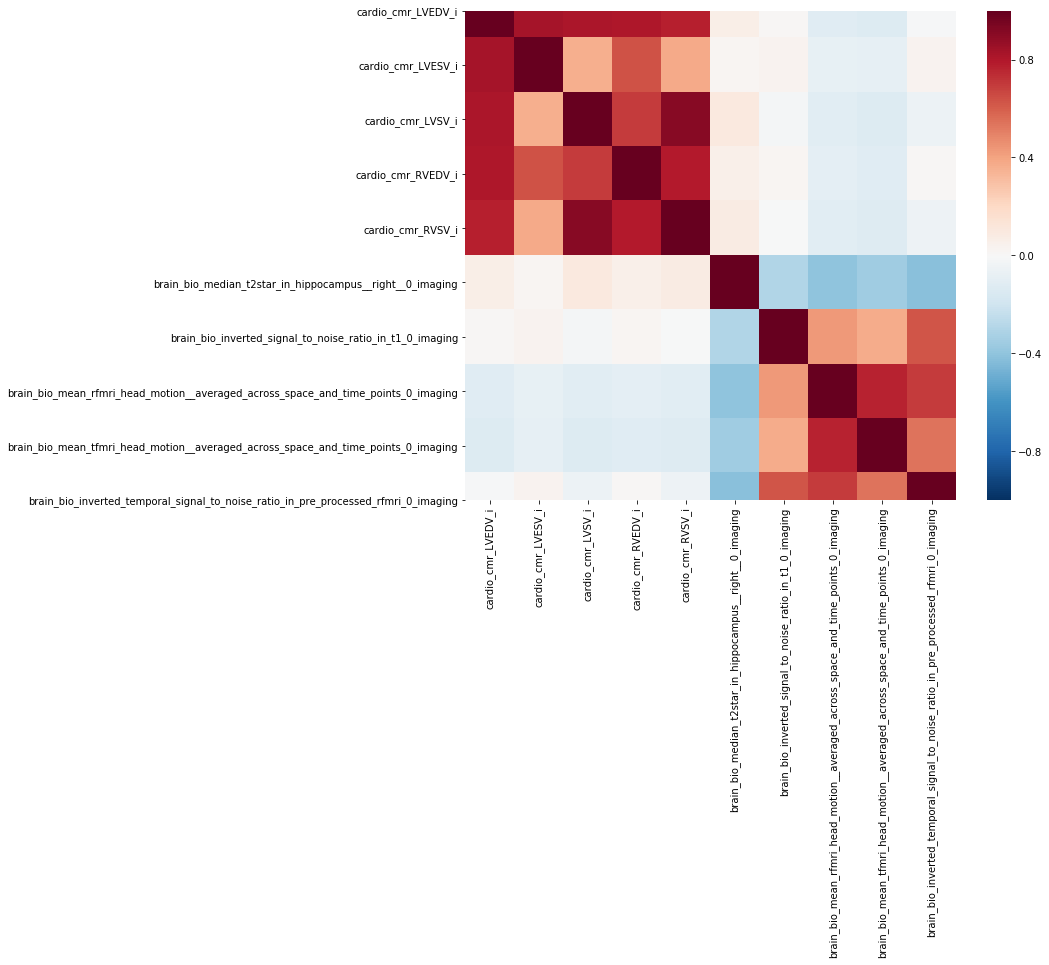

In [83]:
cmr_brain_corr = corr_cmr_brain.corr()
plt.figure(figsize=(11,9))
sns.heatmap(cmr_brain_corr, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
plt.show()

In [84]:
cmr_brain_corr

,cardio_cmr_LVEDV_i,cardio_cmr_LVESV_i,cardio_cmr_LVSV_i,cardio_cmr_RVEDV_i,cardio_cmr_RVSV_i,brain_bio_median_t2star_in_hippocampus__right__0_imaging,brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging,brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging,brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging
cardio_cmr_LVEDV_i,1.000000,0.832724,0.818599,0.806088,0.774736,0.069795,0.011332,-0.119604,-0.136510,-0.010840
cardio_cmr_LVESV_i,0.832724,1.000000,0.363647,0.636581,0.377506,0.021516,0.034756,-0.083726,-0.092079,0.036283
cardio_cmr_LVSV_i,0.818599,0.363647,1.000000,0.695825,0.911827,0.095106,-0.016989,-0.114372,-0.134150,-0.055876
cardio_cmr_RVEDV_i,0.806088,0.636581,0.695825,1.000000,0.796017,0.058688,0.019703,-0.095598,-0.121540,0.008033
cardio_cmr_RVSV_i,0.774736,0.377506,0.911827,0.796017,1.000000,0.082557,-0.006661,-0.116529,-0.130178,-0.048988
brain_bio_median_t2star_in_hippocampus__right__0_imaging,0.069795,0.021516,0.095106,0.058688,0.082557,1.000000,-0.300674,-0.402202,-0.356125,-0.416952
brain_bio_inverted_signal_to_noise_ratio_in_t1_0_imaging,0.011332,0.034756,-0.016989,0.019703,-0.006661,-0.300674,1.000000,0.432335,0.370281,0.627819
brain_bio_mean_rfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.119604,-0.083726,-0.114372,-0.095598,-0.116529,-0.402202,0.432335,1.000000,0.770301,0.695842
brain_bio_mean_tfmri_head_motion__averaged_across_space_and_time_points_0_imaging,-0.136510,-0.092079,-0.134150,-0.121540,-0.130178,-0.356125,0.370281,0.770301,1.000000,0.541515
brain_bio_inverted_temporal_signal_to_noise_ratio_in_pre_processed_rfmri_0_imaging,-0.010840,0.036283,-0.055876,0.008033,-0.048988,-0.416952,0.627819,0.695842,0.541515,1.000000


# 2. References

[1] [Pedregosa, F. et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf). Scikit-learn: Machine Learning in Python.